In [ ]:
import torch
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
%matplotlib inline

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# 1) Write a Variational Convolutional AutoEncoder on CFAR10 + Add denoising to the model

In [ ]:
epoch = 30
batch_size =100
learning_rate = 0.001

transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transformations)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transformations)

train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                      batch_size=batch_size, 
                                      shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                    batch_size=batch_size, 
                                    shuffle=False)  

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class VAE(nn.Module):
    def __init__(self, h_dim = 256*8*8, z_dim = 2048):
        super(VAE, self).__init__()

        ################## ENCODER PART #########################

        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(3,16,3,padding=1),   # batch x 16 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
                        )
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 8 x 8
                        nn.ReLU()
                        )
        self.fc31 = nn.Linear( h_dim, z_dim)
        self.fc32 = nn.Linear( h_dim, z_dim)
        
       ################## DECODER PART #########################
        self.fc4 = nn.Linear(z_dim, h_dim)

        self.d_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.d_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )

    def encoder(self, x):
      h = self.e_layer1(x)

      h = self.e_layer2(h)
      
      ### FLATTEN THE ENCODED OUTPUT
      h = h.view(h.size(0), -1)

      return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
      h = F.relu(self.fc4(z))

      # UNFLATTEN SAMPLE TO PASS TO TRANSPOSED CONVOLUTION LAYERS TO RECONSTRUCT
      h = h.view(h.size(0), 256 , 8, 8)
      
      # PASS TO DECODER 
      h = self.d_layer1(h)
      h = self.d_layer2(h)
      h = F.sigmoid(h)

      return h

    def forward(self, x):
      mu, log_var = self.encoder(x)
      z = self.sampling(mu, log_var)
      return self.decoder(z), mu, log_var
         

            
# build model
vae = VAE(h_dim = 256*8*8,  z_dim= 2048)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
vae

VAE(
  (e_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, mome

In [ ]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')

    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            image_n = torch.mul(data+0.1, 0.01 * torch.rand(batch_size,3,32,32).cuda())  ##  ADDED NOISE 
            image_n = image_n.cuda()
        optimizer.zero_grad()
     
        recon_batch, mu, log_var = vae(image_n)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            loss = loss_function(recon, data, mu, log_var).item()
            test_loss += loss
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1,5):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss: 3146.898750
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2129.550313
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2129.349062
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2129.348281
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2129.348281
====> Epoch: 1 Average loss: 2145.2215
====> Test set loss: 2129.3481
Train Epoch: 2 [0/50000 (0%)]	Loss: 2129.348125
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2129.348125
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2129.348125
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2129.348125
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2129.348125
====> Epoch: 2 Average loss: 2129.3481
====> Test set loss: 2129.3481
Train Epoch: 3 [0/50000 (0%)]	Loss: 2129.348281
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2129.348125
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2129.348125
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2129.348125
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2129.348125
====> Epoch: 3 Average loss: 2129.3481
====> Test set loss: 2129.3481
Train Epoc

In [ ]:
import IPython,os

with torch.no_grad():
    z = torch.randn(64, 2048).cuda()
    sample = vae.decoder(z).cuda()
    
    if torch.cuda.is_available():
        z=z.cuda()
        sample=sample.cuda()
    
    save_image(sample.view(64, 3, 32, 32), './sample_data/sample_' + '.png')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


--------------------------./sample_data-------------------------
sample_.png


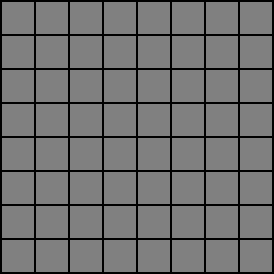

In [ ]:
from PIL import Image
import os, os.path
import IPython

imgs = []
paths = ["./sample_data"]
for path in paths:
    print("--------------------------"+path+"-------------------------")
    valid_images = [".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        print(f)
        display(IPython.display.Image(os.path.join(path,f),width=900))

# 2) Use the latent space for CIFAR10 classification



In [ ]:
# Simple Convolutional Autoencoder

import torch
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
epoch = 30
batch_size =100
learning_rate = 0.0005


trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                      batch_size=batch_size, 
                                      shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                    batch_size=batch_size, 
                                    shuffle=False)  

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,16,3,padding=1),   # batch x 16 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 8 x 8
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder()
if torch.cuda.is_available():
    encoder = encoder.cuda()

In [ ]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,8,8)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder()
if torch.cuda.is_available():
    decoder=decoder.cuda()

In [ ]:
class LatentClassifier(nn.Module):
  def __init__(self):
    super(LatentClassifier,self).__init__()
    input_size = 16384
    hidden_size_1 = 512
    hidden_size_2 = 64
    output_size = 10
    self.l1 = nn.Linear(input_size, hidden_size_1)
    self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.l3 = nn.Linear(hidden_size_2, output_size)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
        
  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return self.softmax(out)


latent_classifier = LatentClassifier().cuda()

In [ ]:
# Check output of Encoder and Decoder 

for image,label in train_loader:
    if torch.cuda.is_available():
        image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([100, 3, 32, 32])


In [ ]:
output[39].shape

torch.Size([3, 32, 32])

In [ ]:
# Check output of Encoder with Latent Classifier

for image,label in train_loader:
    if torch.cuda.is_available():
        image = image.cuda()
    
    output = encoder(image)
    output = latent_classifier(output)
    print(output.size())
    break

torch.Size([100, 10])


In [ ]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train encoder and decoder
# save and load model


for i in range(epoch):
    for image,label in train_loader:
        image_n = torch.mul(image+0.25, 0.01 * torch.rand(batch_size,3,32,32))
        if torch.cuda.is_available():
            image = image.cuda()
            image_n = image_n.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)

epoch [1/10], loss:0.0064
epoch [2/10], loss:0.0055
epoch [3/10], loss:0.0056
epoch [4/10], loss:0.0052
epoch [5/10], loss:0.0053
epoch [6/10], loss:0.0052
epoch [7/10], loss:0.0048
epoch [8/10], loss:0.0046
epoch [9/10], loss:0.0053
epoch [10/10], loss:0.0044
tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


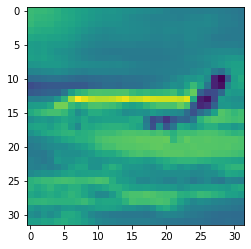

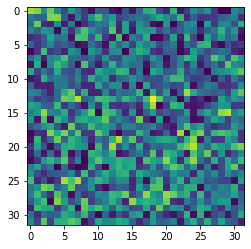

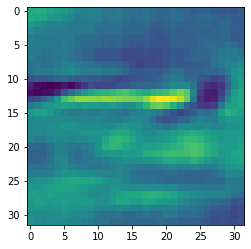

tensor(0)


In [ ]:
# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
img = image[39].reshape(3, 32, 32).cpu()
input_img = image_n[39].cpu()
output_img = output[39].cpu()

print(img.shape)
print(input_img.shape)
print(output_img.shape)

origin = img.numpy()
inp = input_img.numpy()
out = output_img.detach().numpy()

plt.imshow(origin[0])
plt.show()

plt.imshow(inp[0])
plt.show()


plt.imshow(out[0])
plt.show()

print(label[39])

In [ ]:
# LOAD AUTOENCODER MODEL

if not os.path.exists('./model'):
    os.mkdir('./model')
try:
    encoder, decoder = torch.load('./model/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [ ]:
parameters = latent_classifier.parameters()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train loaded encoder and classifier
# save and load model


for i in range(epoch):
    for image,label in train_loader:
        #image_n = torch.mul(image+0.25, 0.1 * torch.rand(batch_size,3,32,32))
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image)
        output = latent_classifier(output)
        loss = loss_func(output,label)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], training loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
    
    correct = 0
    total = 0


    for image, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        image = image.cuda()
          
        # Forward pass only to get logits/output
        output = encoder(image)
        output = latent_classifier(output)
          
        # Get predictions from the maximum value
        _, predicted = torch.max(output.data, 1)
          
        # Total number of labels
        total += labels.size(0)
          
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        correct += (predicted.cpu() == labels.cpu()).sum().float()
      
    accuracy = 100. * correct / total
    print('epoch [{}/{}], testing accuracy:{:.4f}'
          .format(i + 1, epoch, accuracy))
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch [1/10], training loss:1.9379
epoch [1/10], testing accuracy:59.2200
epoch [2/10], training loss:1.7871
epoch [2/10], testing accuracy:61.3700
epoch [3/10], training loss:1.8500
epoch [3/10], testing accuracy:61.9100
epoch [4/10], training loss:1.7186
epoch [4/10], testing accuracy:60.2900
epoch [5/10], training loss:1.7436
epoch [5/10], testing accuracy:63.3300
epoch [6/10], training loss:1.7230
epoch [6/10], testing accuracy:63.5400
epoch [7/10], training loss:1.7399
epoch [7/10], testing accuracy:63.5300
epoch [8/10], training loss:1.7831
epoch [8/10], testing accuracy:63.7700
epoch [9/10], training loss:1.8037
epoch [9/10], testing accuracy:64.4100
epoch [10/10], training loss:1.7404
epoch [10/10], testing accuracy:65.5100


# 3) Write Adam optimizer in PyTorch (without using nn.Adam!)

In [ ]:
import numpy as np
import torch
import torch.nn as NN
from torch.optim.optimizer import Optimizer, required
import math

# This code follows the original paper: https://arxiv.org/pdf/1412.6980.pdf
class AdamOptimizer(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamOptimizer, self).__init__(params, defaults)
        
    def step(self):
        loss = None
        for group in self.param_groups:

            for p in group['params']:
                pGrad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    
                m, v= state['m'], state['v']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # weight decay if it is required.
                if group['weight_decay'] != 0:
                    pGrad = pGrad.add(group['weight_decay'], p.data)

                # first moment vector
                m = torch.mul(m, b1) + (1 - b1)*pGrad
                # secod moment vector
                v = torch.mul(v, b2) + (1-b2)*(pGrad*pGrad)
            

                mCap = torch.mul(m,1 / (1 - b1 ** state['step']))
                vCap = torch.mul(v,1 / (1 - b2 ** state['step']))

                denom = vCap.sqrt() + group['eps']
                
                deltaP =  group['lr']*mCap / denom

                p.data = p.data - deltaP
                
                if state['step']  % 10000 ==0:
                    print ("group:", group)
                    print("p: ",p)
                    print("p.data: ", p.data) 
                
        return loss


# Extra point: Write a Convolutional Variational Auto Encoder and use PixelShuffle instead of TransposeConv

In [ ]:
import torch
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
%matplotlib inline

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
epoch = 30
batch_size =100
learning_rate = 0.001

transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transformations)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transformations)

train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                      batch_size=batch_size, 
                                      shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                    batch_size=batch_size, 
                                    shuffle=False)  

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class VAE_SHUFFLE(nn.Module):
    def __init__(self, h_dim = 192*4*4, z_dim = 1024):
        super(VAE_SHUFFLE, self).__init__()

        ################## ENCODER PART #########################

        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(3,16,3,padding=1),   # batch x 16 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
                        )
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,192,3,padding=1),  # batch x 192 x 8 x 8
                        nn.ReLU(),
                        nn.MaxPool2d(2,2)
                        )
        self.fc31 = nn.Linear( h_dim, z_dim)
        self.fc32 = nn.Linear( h_dim, z_dim)
        
       ################## DECODER PART #########################
        self.fc4 = nn.Linear(z_dim, h_dim)


        pixel_shuffle = nn.PixelShuffle(2)

        self.d_layer1 = nn.Sequential(
                        nn.PixelShuffle(2),
                        nn.ReLU(),
                        nn.PixelShuffle(2),
                        nn.ReLU(),
                        nn.PixelShuffle(2),
                        nn.ReLU()
        )

    def encoder(self, x):
      h = self.e_layer1(x)

      h = self.e_layer2(h)
      
      ### FLATTEN THE ENCODED OUTPUT
      h = h.view(h.size(0), -1)

      return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
      h = F.relu(self.fc4(z))

      #print(h.shape)

      # UNFLATTEN SAMPLE TO PASS TO TRANSPOSED CONVOLUTION LAYERS TO RECONSTRUCT
      h = h.view(h.size(0), 192 , 4, 4)
      
      # PASS TO DECODER 
      h = self.d_layer1(h)
      #h = self.d_layer2(h)
      h = F.sigmoid(h)

      return h

    def forward(self, x):
      mu, log_var = self.encoder(x)
      z = self.sampling(mu, log_var)
      #print("z", z.shape)
      return self.decoder(z), mu, log_var
         

            
# build model
vae_shuffle = VAE_SHUFFLE(h_dim = 192*4*4,  z_dim= 1024)
if torch.cuda.is_available():
    vae_shuffle.cuda()

In [ ]:
vae_shuffle

VAE_SHUFFLE(
  (e_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-

In [ ]:
optimizer = optim.Adam(vae_shuffle.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')

    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

In [ ]:
def train(epoch):
    vae_shuffle.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            image_n = torch.mul(data+0.1, 0.01 * torch.rand(batch_size,3,32,32).cuda())  ##  ADDED NOISE 
            image_n = image_n.cuda()
        optimizer.zero_grad()
     
        recon_batch, mu, log_var = vae_shuffle(image_n)
        
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test():
    vae_shuffle.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
            recon, mu, log_var = vae_shuffle(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1,5):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss: 2646.770312
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2129.488750
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2129.392813
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2129.368125
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2129.358438
====> Epoch: 1 Average loss: 2131.5205
====> Test set loss: 2311.8389
Train Epoch: 2 [0/50000 (0%)]	Loss: 2129.354063
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2129.352188
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2129.351562
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2129.351094
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2129.351094
====> Epoch: 2 Average loss: 2129.3568
====> Test set loss: 163732291272.7130
Train Epoch: 3 [0/50000 (0%)]	Loss: 2129.383125
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2129.356875
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2129.353281
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2129.291563
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2129.400625
====> Epoch: 3 Average loss: 2129.4869
====> Test set loss: inf
Train Ep

In [ ]:
import IPython,os

with torch.no_grad():
    z = torch.randn(64, 1024).cuda()
    sample = vae_shuffle.decoder(z).cuda()
    
    if torch.cuda.is_available():
        z=z.cuda()
        sample=sample.cuda()
    
    save_image(sample.view(64, 3, 32, 32), './sample_data/sample_' + '.png')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


--------------------------./sample_data-------------------------
sample_.png


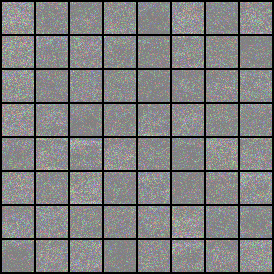

In [ ]:
from PIL import Image
import os, os.path
import IPython

imgs = []
paths = ["./sample_data"]
for path in paths:
    print("--------------------------"+path+"-------------------------")
    valid_images = [".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        print(f)
        display(IPython.display.Image(os.path.join(path,f),width=900))

# Extra point: To do your previous assignment (robot classification) on latent space of a trained CAE

In [ ]:
cd /content/Sheet5

/content/Sheet5


In [ ]:
!unzip robots.zip

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from matplotlib.pyplot import figure

In [ ]:
batch_size = 10

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'robots'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#image_datasets['train'].classes = ['not_robot', 'robot']

class_names = image_datasets['train'].classes

avDev = torch.device("cuda")


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,16,3,padding=1),   # batch x 16 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 8 x 8
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder()
if torch.cuda.is_available():
    encoder = encoder.cuda()


# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder()
if torch.cuda.is_available():
    decoder=decoder.cuda()

In [ ]:
# Check output of Encoder and Decoder 

for image,label in dataloaders['train']:
    if torch.cuda.is_available():
        image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([10, 3, 224, 224])


In [ ]:
image.shape

torch.Size([32, 3, 224, 224])

In [ ]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train encoder and decoder
# save and load model


for i in range(epoch):
    for image,label in dataloaders['train']:
        image_n = torch.mul(image+0.25, 0.01 * torch.rand(batch_size,3,224,224))
        if torch.cuda.is_available():
            image = image.cuda()
            image_n = image_n.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
torch.save([encoder,decoder],'./model/robot_deno_autoencoder.pkl')
print(loss)

epoch [1/10], loss:0.7896
epoch [2/10], loss:0.7996
epoch [3/10], loss:1.1216
epoch [4/10], loss:0.8402
epoch [5/10], loss:0.7843
epoch [6/10], loss:0.6435
epoch [7/10], loss:0.8755
epoch [8/10], loss:1.0136
epoch [9/10], loss:0.8485
epoch [10/10], loss:0.7161
tensor(0.7161, device='cuda:0', grad_fn=<MseLossBackward>)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


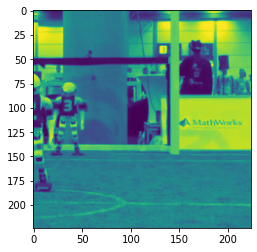

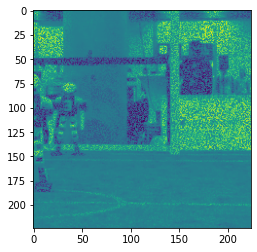

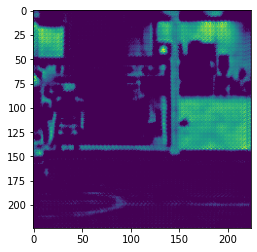

tensor(1)


In [ ]:
# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
img = image[5].cpu()
input_img = image_n[5].cpu()
output_img = output[5].cpu()

print(img.shape)
print(input_img.shape)
print(output_img.shape)

origin = img.numpy()
inp = input_img.numpy()
out = output_img.detach().numpy()

plt.imshow(origin[0])
plt.show()

plt.imshow(inp[0])
plt.show()


plt.imshow(out[0])
plt.show()

print(label[5])

In [ ]:
class LatentClassifier(nn.Module):
  def __init__(self):
    super(LatentClassifier,self).__init__()
    input_size = 802816
    hidden_size_1 = 512
    hidden_size_2 = 64
    output_size = 2
    self.l1 = nn.Linear(input_size, hidden_size_1)
    self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.l3 = nn.Linear(hidden_size_2, output_size)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
        
  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return self.softmax(out)


latent_classifier = LatentClassifier().cuda()

In [ ]:
# LOAD AUTOENCODER MODEL

if not os.path.exists('./model'):
    os.mkdir('./model')
try:
    encoder, decoder = torch.load('./model/robot_deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [ ]:
# Check output of Encoder with Latent Classifier

for image,label in dataloaders['train']:
    if torch.cuda.is_available():
        image = image.cuda()
    
    output = encoder(image)
    output = latent_classifier(output)
    print(output.size())
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([10, 2])


In [ ]:
parameters = latent_classifier.parameters()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
# train loaded encoder and classifier
# save and load model


for i in range(epoch):
    for image,label in dataloaders['train']:
        #image_n = torch.mul(image+0.25, 0.1 * torch.rand(batch_size,3,32,32))
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image)
        output = latent_classifier(output)
        loss = loss_func(output,label)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], training loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
    
    if i % 2 == 0:
      correct = 0
      total = 0


      for image, labels in dataloaders['val']:
          #######################
          #  USE GPU FOR MODEL  #
          #######################
          image = image.cuda()
          
          # Forward pass only to get logits/output
          output = encoder(image)
          output = latent_classifier(output)

          
            
          # Get predictions from the maximum value
          _, predicted = torch.max(output.data, 1)
            
          # Total number of labels
          total += labels.size(0)
            
          #######################
          #  USE GPU FOR MODEL  #
          #######################
          # Total correct predictions
          correct += (predicted.cpu() == labels.cpu()).sum().float()
        
      accuracy = 100. * correct / total
      print('epoch [{}/{}], testing accuracy:{:.4f}'
            .format(i + 1, epoch, accuracy))
          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch [1/10], training loss:0.9133
epoch [1/10], testing accuracy:54.0000
epoch [2/10], training loss:0.5133
epoch [3/10], training loss:0.5133
epoch [3/10], testing accuracy:54.0000
epoch [4/10], training loss:0.6133
epoch [5/10], training loss:0.4133
epoch [5/10], testing accuracy:54.0000
epoch [6/10], training loss:0.6133
epoch [7/10], training loss:0.9133
epoch [7/10], testing accuracy:54.0000
epoch [8/10], training loss:0.8133
epoch [9/10], training loss:0.8133
epoch [9/10], testing accuracy:54.0000
epoch [10/10], training loss:0.5133
